In [1]:
from alibi.explainers import Counterfactual

import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [3]:
model = pickle.load(open('model/model.pkl', 'rb'))
training_data = pickle.load(open('model/training_data.pkl', 'rb'))

In [4]:
model[0].feature_names_in_ = None

In [5]:
x_train = training_data[training_data.columns[:-1]]

In [6]:
np.quantile(x_train.values, 0.95, axis=0).reshape(1,-1)

array([[  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  , 

In [7]:
def predict_fn(x): 
    prediction_array = np.array(x)
    if len(prediction_array.shape) == 1:
        prediction_array = np.array([prediction_array])
        
    return model.predict_proba(prediction_array)

cf = Counterfactual(
    predict_fn,
    shape = (1,) + x_train.shape[1:], # shape of input data
    feature_range = (np.quantile(x_train.values, 0.05, axis=0).reshape(1,-1), np.quantile(x_train.values, 0.95, axis=0).reshape(1,-1)), # feature range for the perturbed counterfactual instance
)

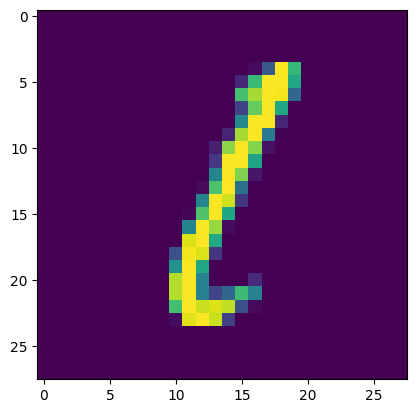

In [8]:
plt.imshow(np.array(x_train.iloc[0]).reshape(28, 28))

In [14]:
id = 0

res = cf.explain(np.array(x_train.iloc[id]).reshape(1, -1))

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


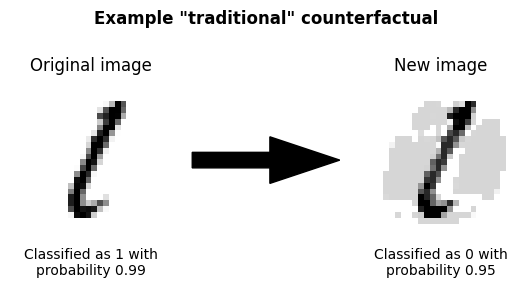

In [17]:

fig, axs = plt.subplots(1, 3)
plt.suptitle('Example "traditional" counterfactual',weight='bold')

# Plot the first image
axs[0].imshow(np.array(training_data.iloc[id][:-1]).astype(np.float32).reshape(28, 28), cmap='binary')
axs[0].set_title('Original image')
axs[0].set_xlabel(f'Classified as {model.predict(pd.DataFrame(training_data.iloc[id][:-1]).T)[0]} with\nprobability {model.predict_proba(pd.DataFrame(training_data.iloc[id][:-1]).T).max():.2f}')

# Add an arrow between the two images
axs[1].arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color='k')
axs[1].set_ylim([0, 1])

# Plot the second image
final = res.cf['X'].reshape(28, 28)
axs[2].imshow(np.array(final).astype(np.float32).reshape(28, 28), cmap='binary')
axs[2].set_title('New image',)
axs[2].set_xlabel(f'Classified as {model.predict(pd.DataFrame(res.cf["X"]))[0]} with\nprobability {model.predict_proba(pd.DataFrame(res.cf["X"])).max():.2f}')


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_aspect('equal')
    
plt.tight_layout()
fig.subplots_adjust(top=1.3)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(left=0.1)
plt.savefig('../../figures/mnist_counterfactual_trad_example.eps',bbox_inches='tight')
plt.show()

array([[<Axes: title={'center': '0'}>]], dtype=object)

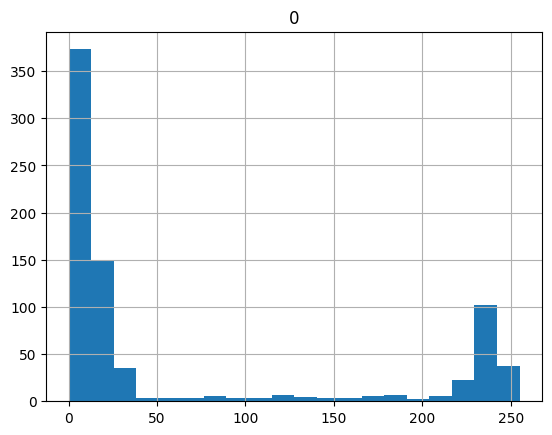

In [ ]:
pd.DataFrame(res.cf['X'].reshape(1,-1)).T.hist(bins=20)